In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv(r'C:\Users\Mohamed Fawzi\Desktop\Warehouse Sales\Warehouse_and_Retail_Sales.csv')

df.head(2)

,YEAR,MONTH,SUPPLIER,ITEM CODE,ITEM DESCRIPTION,ITEM TYPE,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES
0,2020,1,REPUBLIC NATIONAL DISTRIBUTING CO,100009,BOOTLEG RED - 750ML,WINE,0.0,0.0,2.0
1,2020,1,PWSWN INC,100024,MOMENT DE PLAISIR - 750ML,WINE,0.0,1.0,4.0


# Cleaning & Preparing The Data

In [2]:
# I will convert all columns name to be title case - I prefer it like that :)
df.columns = df.columns.str.title()

In [3]:
# drop null values
df.dropna(inplace=True)

In [4]:
df.isna().sum()

Year                0
Month               0
Supplier            0
Item Code           0
Item Description    0
Item Type           0
Retail Sales        0
Retail Transfers    0
Warehouse Sales     0
dtype: int64

In [5]:
# exclude 'STR_SUPPLIES', 'KEGS', 'REF', 'DUNNAGE', because most of the values are zeros
df = df[df['Item Type'].isin(['WINE', 'BEER', 'LIQUOR','NON-ALCOHOL'])]

In [6]:
df['Item Type'].unique()


array(['WINE', 'BEER', 'LIQUOR', 'NON-ALCOHOL'], dtype=object)

In [7]:
# Calculate mean values for only saleable items
saleable_items = ['WINE', 'BEER', 'LIQUOR', 'NON-ALCOHOL']  # Define saleable items
mean_values = df[df['Item Type'].isin(saleable_items)].groupby('Item Type')[['Warehouse Sales', 'Retail Transfers', 'Retail Sales']].mean()

# Define a function to replace zeros
def replace_zeros_with_mean(row, mean_values):
    item_type = row['Item Type']
    for col in ['Warehouse Sales', 'Retail Transfers', 'Retail Sales']:
        if row[col] == 0.0 and item_type in mean_values.index:
            row[col] = mean_values.loc[item_type, col]  # Replace zero with mean for this item type
    return row

# Apply the function to rows where the item type is saleable
df = df.apply(replace_zeros_with_mean, mean_values=mean_values, axis=1)

In [8]:
df.sample()

,Year,Month,Supplier,Item Code,Item Description,Item Type,Retail Sales,Retail Transfers,Warehouse Sales
228853,2019,6,BACCHUS IMPORTERS LTD,45069,AVALON NAPA CAB - 750ML,WINE,0.48,3.91504,3.0


In [9]:
# converting the Year & Month to datetime
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str))

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296862 entries, 0 to 307644
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Year              296862 non-null  int64         
 1   Month             296862 non-null  int64         
 2   Supplier          296862 non-null  object        
 3   Item Code         296862 non-null  object        
 4   Item Description  296862 non-null  object        
 5   Item Type         296862 non-null  object        
 6   Retail Sales      296862 non-null  float64       
 7   Retail Transfers  296862 non-null  float64       
 8   Warehouse Sales   296862 non-null  float64       
 9   Date              296862 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 24.9+ MB


In [10]:
# Convert numeric columns to float
numeric_columns = ['Retail Sales', 'Retail Transfers', 'Warehouse Sales']

df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
#df.info()


In [11]:
# extract month name from the date column that I created earlier
df['Month Name'] = df['Date'].dt.month_name()

# Exploratory Data Analysis (EDA):

## Time Series Trend

In [12]:
monthly_sales = df.groupby('Month Name')[['Warehouse Sales', 'Retail Sales']].sum().reset_index().round(2)

month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

# order by month name
monthly_sales['Month Name'] = pd.Categorical(monthly_sales['Month Name'], categories=month_order, ordered=True)
monthly_sales.head(2)

,Month Name,Warehouse Sales,Retail Sales
0,April,325981.52,110407.22
1,August,797203.68,234754.87


In [13]:
# melt the dataframe for plotting.
monthly_sales_melted = monthly_sales.melt(id_vars='Month Name', var_name='Sales Type', value_name='Sales')
monthly_sales_melted.head(2)

,Month Name,Sales Type,Sales
0,April,Warehouse Sales,325981.52
1,August,Warehouse Sales,797203.68


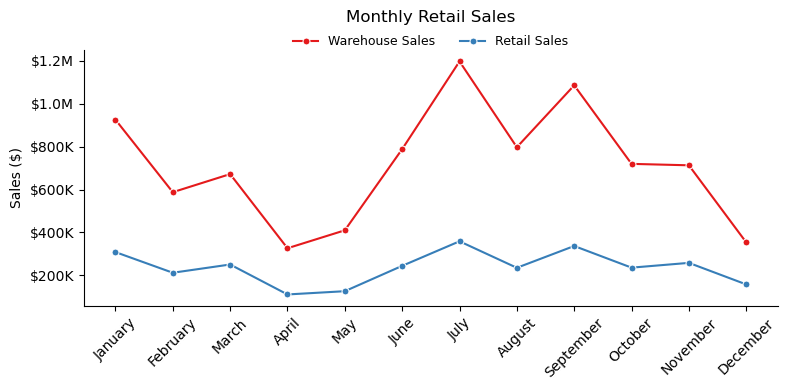

In [14]:
plt.figure(figsize=(8, 4))
sns.lineplot(
            data=monthly_sales_melted,
             x='Month Name',
             y='Sales',
             hue='Sales Type',
             palette='Set1',
             marker='o',
             markersize=5,



        )

def format_currency(x, pos):
    if x >= 1e6:
        return '${:1.1f}M'.format(x*1e-6)
    else:
        return '${:1.0f}K'.format(x*1e-3)

# Apply the currency format to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_currency))

plt.title('Monthly Retail Sales', pad=20)
plt.xlabel('')
plt.ylabel('Sales ($)')

plt.xticks(rotation=45)
plt.legend(ncols=2, loc='upper center', frameon=False, bbox_to_anchor=(0.5, 1.1), fontsize=9)

sns.despine()
plt.tight_layout()
plt.show()


Here are some key insights from the Monthly Retail Sales chart:
-   Warehouse Sales Are Consistently Higher:

    -   Throughout the year, warehouse sales significantly outperform retail sales, often by more than double.

-   Peak Sales Months:

    -   July marks the highest month for warehouse sales (~$1.2M).

    -   Retail sales also peak in July (~$350K), suggesting seasonal or promotional factors affecting both channels.

-   Lowest Sales Periods:

    -   April is the weakest month for both warehouse and retail sales, particularly low for retail (~$100K).

-   Seasonal Trends:

    -   Warehouse sales exhibit more volatility with large spikes (June–July, September).

    -   Retail sales are relatively stable with moderate fluctuations.

-----

### Average Monthly Sales:


In [15]:
# Monthly seasonality pattern
seasonality = df.groupby('Month Name')[['Warehouse Sales', 'Retail Sales']].mean().reset_index().round(2)
seasonality['Month Name'] = pd.Categorical(seasonality['Month Name'], categories=month_order, ordered=True)
seasonality_melted = seasonality.melt(id_vars='Month Name', var_name='Sales Type', value_name='Sales')

seasonality_melted.head(2)

,Month Name,Sales Type,Sales
0,April,Warehouse Sales,26.56
1,August,Warehouse Sales,31.91


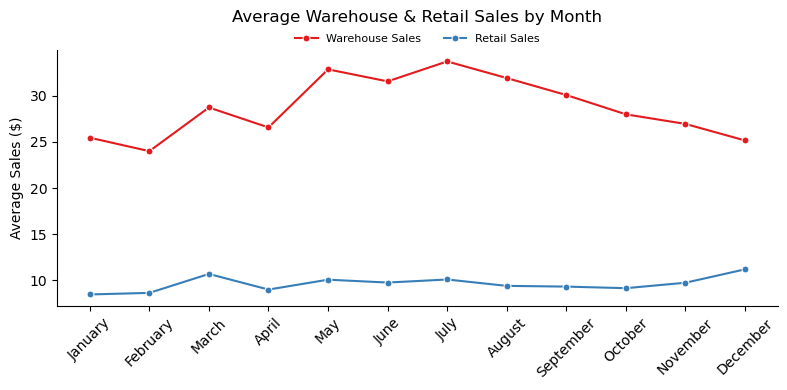

In [16]:
plt.figure(figsize=(8,4))
sns.lineplot(
        data=seasonality_melted,
    x='Month Name',
    y='Sales',
    hue='Sales Type',
        palette='Set1',
        marker='o',
        markersize=5,

)

plt.title('Average Warehouse & Retail Sales by Month', pad=20)
plt.xlabel('')
plt.ylabel('Average Sales ($)')
plt.xticks(rotation=45)

plt.legend(ncols=2, loc='upper center', frameon=False, bbox_to_anchor=(0.5, 1.1), fontsize=8)
sns.despine()
plt.tight_layout()
plt.show()



### **Key Insights**

1. **July Is the Peak for Both Channels**:

   * **Warehouse Sales** peak in **July (\~\$34)**, followed closely by **May and June**.
   * **Retail Sales** also show a smaller peak in **December (\~\$11)** and **March**.

2. **Warehouse Sales Show a Strong Mid-Year Surge**:

   * From **April to July**, there's a noticeable rise in average warehouse sales, suggesting increased B2B demand or bulk purchasing during this period.

3. **Retail Sales Are Steadier But Lower**:

   * Retail sales fluctuate mildly between **\$8 and \$11**, showing more stability but consistently lower values than warehouse sales.

-----

